<a href="https://colab.research.google.com/github/straylight77/data-sci-learning/blob/master/titanic/titanic4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data_raw = pd.read_csv('https://raw.githubusercontent.com/straylight77/data-sci-learning/master/titanic/train.csv')
data = data_raw.copy(deep=True)

data.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
444,445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S
400,401,1,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S


In [0]:
####################################################################
# clean the data



In [0]:
# feature engineering 


In [2]:
#####################################################################
# prepare training data 
y = data.Survived

features = ['Pclass', 'SibSp', 'Parch', 'Fare' ]
X = data[features]

# split into validation and training data
#   train_X = data to be used to train a model (with labels in train_y)
#   val_X = data to be used to measure accuracy (compare predictions with val_y) 
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
print("training data rows: ", len(train_X))
print(" testing data rows: ", len(val_X))
print("original data rows: ", len(X))

training data rows:  668
 testing data rows:  223
original data rows:  891


In [11]:
# create a model, train it and make predictions using the split validation data
model = RandomForestClassifier(random_state=1)
model.fit(train_X, train_y)

y_preds = model.predict(val_X)
print("Predicted rows: ", len(y_preds))

Predicted rows:  223


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 66.81614349775785%


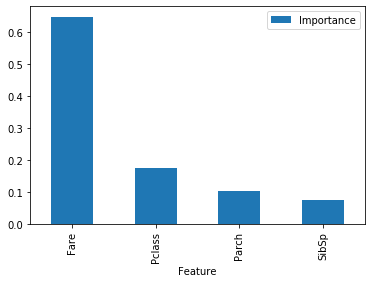

In [12]:
# measure accuracy and print
accuracy_pct = metrics.accuracy_score(val_y, y_preds) * 100
print(f"Accuracy: {accuracy_pct}%")

# measure the relative importance of each feature and plot 
stats = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
})
stats.sort_values(by='Importance', ascending=False, inplace=True)
stats.plot.bar(x='Feature', y='Importance');

In [0]:
#####################################################################
# get predictions for competition data and prepare output file for submission
#data_pred = pd.read_csv('https://raw.githubusercontent.com/straylight77/data-sci-learning/master/titanic/test.csv')
